In [69]:
using HDF5
using PyCall
@pyimport matplotlib.animation as anim
using PyPlot
using Statistics

In [12]:
include("/Users/rzhoufias.uni-frankfurt.de/Documents/Code/PIV/multi_quickPIV/src/multi_quickPIV.jl")

Main.multi_quickPIV

In [15]:
include("/Users/rzhoufias.uni-frankfurt.de/Documents/Code/PIV/multiscale_multistep_filter.jl")

multiscale_multigrid_gradient_segment (generic function with 1 method)

In [18]:
using ImageAnalysis 

# Read .h5 single slice data

In [3]:
function read_h5(folder_path::String, data_name::String)
    h5open(folder_path, "r") do file
        read(file, data_name)
    end
end

read_h5 (generic function with 1 method)

In [4]:
file_path = "/Users/rzhoufias.uni-frankfurt.de/Documents/PhD_Franziska/Headon/data_featherbud_formation_chicken/headon_video1_layer0.h5"
periderm_img = Float16.(read_h5(file_path, "data"))

1024×1024×395 Array{Float16, 3}:
[:, :, 1] =
  53.0   90.0   65.0       97.0   64.0  …   46.0   41.0   47.0      34.0
  50.0   17.0   49.0       45.0   75.0      24.0   59.0  165.0      16.0
  26.0   35.0   19.0       29.0   19.0      49.0   55.0   25.0      58.0
  48.0   44.0   26.0       19.0   44.0      58.0   30.0   31.0      21.0
  44.0   41.0   53.0       77.0  661.0      36.0   61.0   70.0      32.0
  35.0  350.0   49.0       53.0   51.0  …   20.0   67.0   64.0      66.0
  56.0   53.0   24.0      449.0   44.0     307.0   28.0  601.0      37.0
  44.0   37.0    1.182e3   47.0   14.0      28.0  525.0   44.0      25.0
  94.0   31.0   67.0       90.0   33.0      35.0   51.0   30.0     630.0
  52.0   52.0   16.0       22.0   32.0      55.0   27.0   46.0      40.0
 669.0  186.0  176.0       82.0   33.0  …   21.0   55.0   33.0      35.0
  26.0   46.0   23.0       23.0   16.0      46.0   49.0   40.0     179.0
  44.0   47.0   66.0       59.0  402.0     428.0   59.0   14.0      57.0
   ⋮  

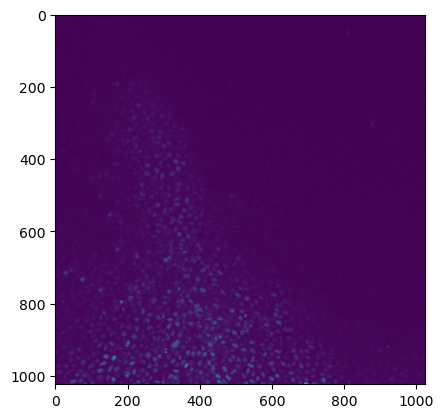

PyObject <matplotlib.image.AxesImage object at 0x16e7fb140>

In [22]:
PyPlot.imshow(periderm_img[:,:,50])

# As for the PIV of Masenchym, also look at the time period of fream 0 - 200. 

This time period contains the main process of aggregate formation. Per observation with eyes, the periderm seems to flow mostly AP direction, with almost no rotation. 

Goal: Clear the AP flow of most of the time. And therefore also discover if there is rotation, or show there is rarly rotation. 
Method: Statistics of dot product between AP vector and PIV vector over time. Pseudo trajectory (? probably not quite useful because a lot of blanc space, but could try)

# Apply PIV on masked image 

Applied multiscale_multistep_filter, since there is a lot of blanck space, the aggregates (and cells in it) have to be extracted to avoid noise from background. Here, the filter would increase the PIV correctniss. 

There exists slight rotations, but not significant... How can I detect them :/ 

hi 
hi 


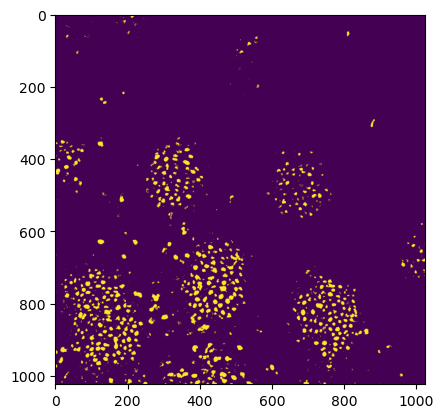

PyObject <matplotlib.image.AxesImage object at 0x1d8d653d0>

In [92]:
# parameter for multiscale multistep filter 
grid_sizes = ( (7,7), )
scales     = ( ((4,4),(2,2)), ) 
steps      = ( ((1,1),(4,4)), ) 

Δ_low = 4000
α = 1.5

img1 = periderm_img[:,:,200]
img2 = periderm_img[:,:,201]

img1_out = multiscale_multistep_filter( Float32.( img1 ), grid_sizes=grid_sizes, scales=scales, steps=steps )
img1_mask = img1_out .> ( img1 .+ Δ_low ) .^ α

img2_out = multiscale_multistep_filter( Float32.( img2 ), grid_sizes=grid_sizes, scales=scales, steps=steps )
img2_mask = img2_out .> ( img1 .+ Δ_low ) .^ α

PyPlot.imshow(img1_mask)

In [43]:
# Parameters for postprocessing
std_factor = 2
function postprocess(M::Matrix{Float16})
    meanM = Statistics.mean(M)
    stdM = Statistics.std(M)
    mask_M = M .<= meanM + std_factor * stdM
    M .*= mask_M
    return M
end

postprocess (generic function with 2 methods)

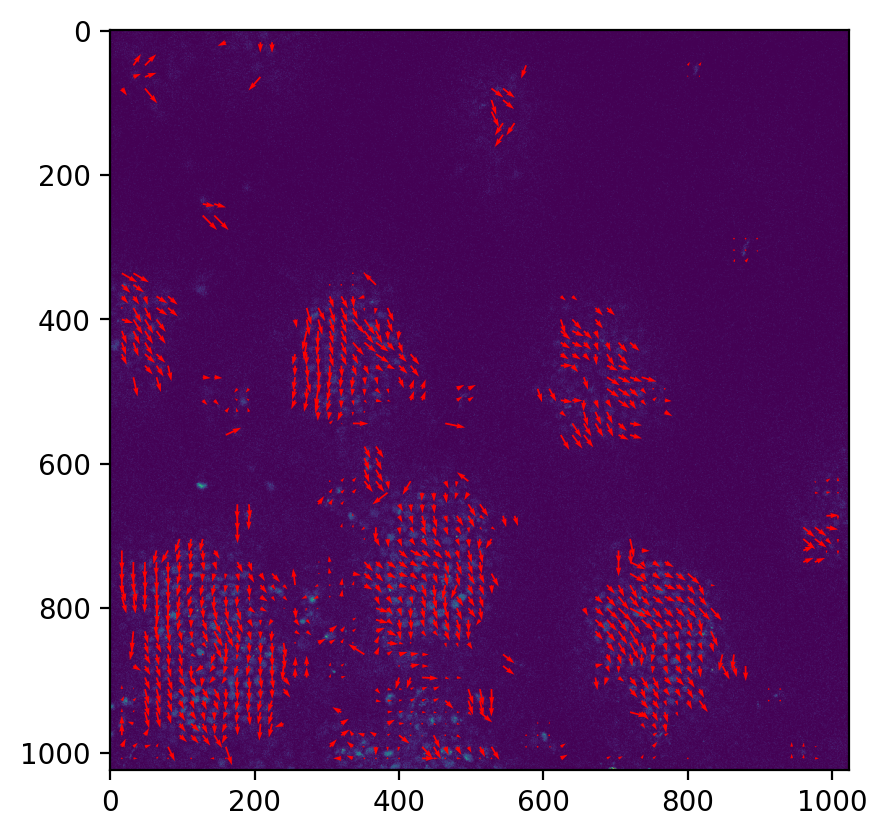

PyObject <matplotlib.quiver.Quiver object at 0x1d86cbfe0>

In [94]:
# paramters for PIV analysis
pivparams = multi_quickPIV.setPIVParameters(interSize=(32, 32), searchMargin=(64, 64), step=(16, 16), computeSN = true)
IA = multi_quickPIV._isize(pivparams)
ST = multi_quickPIV._step(pivparams)


VF, SN = multi_quickPIV.PIV( img1_mask, img2_mask, pivparams, precision=16 )

U = VF[ 1, :, : ]
# U.*= ( SN .> 1 )
V = VF[ 2, :, : ]
# V.*= ( SN .> 1 )
M = sqrt.( U .^ 2 .+ V .^ 2 )# Magnitude of the vectors.

U[ M .> 5 ] .= NaN
V[ M .> 5 ] .= NaN

ygrid = [ ( y - 1 )*ST[1] + div( IA[1], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
xgrid = [ ( x - 1 )*ST[2] + div( IA[2], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]

PyPlot.figure( dpi=200 )
PyPlot.imshow( img1)
PyPlot.quiver( xgrid, ygrid, V, -U, color="red", scale=180)

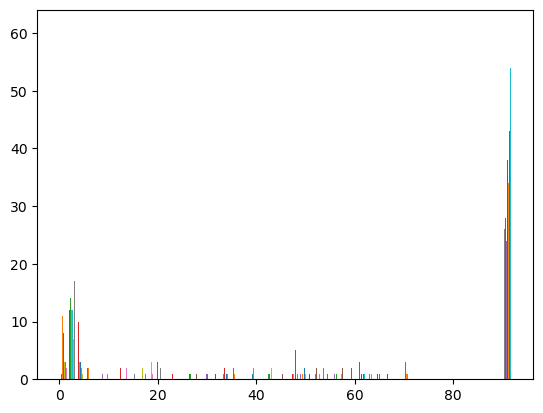

([5.0 12.0 … 0.0 21.0; 8.0 6.0 … 0.0 24.0; … ; 3.0 2.0 … 0.0 46.0; 6.0 2.0 … 1.0 48.0], [0.0, 1.8384776310850237, 3.6769552621700474, 5.515432893255071, 7.353910524340095, 9.19238815542512, 11.030865786510143, 12.869343417595166, 14.70782104868019, 16.546298679765215  …  75.37758287448597, 77.216060505571, 79.05453813665602, 80.89301576774105, 82.73149339882606, 84.56997102991109, 86.40844866099611, 88.24692629208114, 90.08540392316617, 91.92388155425118], NTuple{50, PyObject}[(PyObject <matplotlib.patches.Rectangle object at 0x1d8d55340>, PyObject <matplotlib.patches.Rectangle object at 0x1d8cd48c0>, PyObject <matplotlib.patches.Rectangle object at 0x1d871f020>, PyObject <matplotlib.patches.Rectangle object at 0x1d7a9fef0>, PyObject <matplotlib.patches.Rectangle object at 0x1d8d55a60>, PyObject <matplotlib.patches.Rectangle object at 0x1d7f5daf0>, PyObject <matplotlib.patches.Rectangle object at 0x1d875cd70>, PyObject <matplotlib.patches.Rectangle object at 0x1d8c95d90>, PyObject <mat

In [93]:
PyPlot.hist(M, bins=50)